In [1]:
from sklearn.ensemble import HistGradientBoostingRegressor
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# loforest and locart functions
from CP2LFI.loforest import ConformalLoforest, tune_loforest_LFI
from CP2LFI.scores import LambdaScore
from CP2LFI.simulations import Simulations, naive, predict_naive_quantile


from scipy import stats
from clover import LocartSplit

from copy import deepcopy

from tqdm import tqdm
import itertools

# Testing BFF for every model of choice:

Plotting and comparing the performance of each method:

In [2]:
def obtain_quantiles(
    kind_model,
    thetas,
    N,
    rng,
    B=1000,
    alpha=0.05,
    min_samples_leaf=100,
    n_estimators = 100,
    K = 50,
    B_valid=1000,
    N_lambda=500,
    K_grid= np.concatenate((np.array([0]), np.arange(20, 85, 5))),
    naive_n=500
):
    # fitting and predicting naive
    naive_quantiles = naive(stat = "BFF", kind_model = kind_model, alpha = alpha, rng = rng, B=B, N=N, naive_n= naive_n)
    naive_list = predict_naive_quantile(kind_model, thetas, naive_quantiles)

    # simulating to fit models
    sim_obj = Simulations(rng=rng, kind_model=kind_model)
    thetas_sim, model_lambdas = sim_obj.BFF_sample(B = B , N = N)

    if thetas_sim.ndim == 1:
        model_thetas = thetas_sim.reshape(-1, 1)
    else:
        model_thetas = thetas_sim

    locart_object = LocartSplit(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    locart_quantiles = locart_object.calib(
        model_thetas, model_lambdas, min_samples_leaf=min_samples_leaf
    )

    # loforest quantiles
    loforest_object = ConformalLoforest(
        LambdaScore, None, alpha=alpha, is_fitted=True, split_calib=False
    )
    loforest_object.calibrate(
        model_thetas, 
        model_lambdas, 
        min_samples_leaf=min_samples_leaf, 
        n_estimators= n_estimators,
        K = K,
    )

    # boosting quantiles
    model = HistGradientBoostingRegressor(
        loss="quantile",
        max_iter=100,
        max_depth=3,
        quantile=1 - alpha,
        random_state=105,
        n_iter_no_change=15,
        early_stopping=True,
    )
    model.fit(model_thetas, model_lambdas)

    # tuned loforest
    if kind_model == "1d_normal":
        theta_valid = sim_obj.rng.uniform(-5, 5, B_valid)
    elif kind_model == "gmm":
        theta_valid = sim_obj.rng.uniform(0, 5, B_valid)
    elif kind_model == "lognormal":
        theta_valid = np.c_[
                sim_obj.rng.uniform(-2.5, 2.5, B_valid), sim_obj.rng.uniform(0.15, 1.25, B_valid)
            ]
        
    lambda_valid = np.zeros((theta_valid.shape[0], N_lambda))
    if theta_valid.ndim == 1:
        K_valid_thetas = theta_valid.reshape(-1, 1)
    else:
        K_valid_thetas = theta_valid

    i = 0
    for theta in theta_valid:
        lambda_valid[i, :] = sim_obj.BFF_sim_lambda(theta, B = N_lambda, N = N)
        i += 1

    K_loforest = tune_loforest_LFI(
        loforest_object, K_valid_thetas, lambda_valid, K_grid=K_grid
    )

    if thetas.ndim == 1:
        valid_thetas = thetas.reshape(-1, 1)
    else:
        valid_thetas = thetas

    # locart quantiles
    idxs = locart_object.cart.apply(valid_thetas)
    list_locart_quantiles = [locart_quantiles[idx] for idx in idxs]

    # loforest
    loforest_cutoffs = loforest_object.compute_cutoffs(valid_thetas)

    # tuned loforest
    loforest_tuned_cutoffs = loforest_object.compute_cutoffs(
        valid_thetas, K=K_loforest
    )

    # boosting
    boosting_quantiles = model.predict(valid_thetas)


    # dictionary of quantiles
    quantile_dict = {
        "naive": naive_list,
        "locart": list_locart_quantiles,
        "loforest_fixed": loforest_cutoffs,
        "loforest_tuned": loforest_tuned_cutoffs,
        "boosting": boosting_quantiles,
    }

    return quantile_dict

Creating function to compare all methods for several $B$ and $N$:

In [3]:
def compute_MAE_N(
    kind_model,
    thetas,
    N=np.array([1, 10, 100, 1000]),
    B=np.array([500, 1000, 5000, 10000, 15000, 20000]),
    alpha=0.05,
    n=1000,
    seed=45,
    n_estimators = 100,
    K = 40,
    min_samples_leaf=100,
    naive_n=500,
): 
    N_list = []
    methods_list = []
    mae_list = []
    se_list = []
    B_list = []

    rng = np.random.default_rng(seed)
    sim_obj = Simulations(rng = rng, kind_model = kind_model)
    for N_fixed in N:
        for B_fixed in B:
            print(f'Computing for B = {B_fixed} and N = {N_fixed}')
            # computing all quantiles for fixed N
            quantiles_dict = obtain_quantiles(
                kind_model,
                thetas,
                N=N_fixed,
                B=B_fixed,
                alpha=alpha,
                min_samples_leaf=min_samples_leaf,
                n_estimators=n_estimators,
                K = K,
                naive_n=naive_n,
                rng = rng
            )
            err_data = np.zeros((thetas.shape[0], 5))
            l = 0
            for theta in thetas:
                # simulating lambdas for testing
                stat = sim_obj.BFF_sim_lambda(theta = theta, B = n, N = N_fixed)
                        
                # comparing coverage of methods
                locart_cover = np.mean(stat <= quantiles_dict["locart"][l])
                loforest_cover = np.mean(stat <= quantiles_dict["loforest_fixed"][l])
                loforest_tuned_cover = np.mean(stat <= quantiles_dict["loforest_tuned"][l])
                boosting_cover = np.mean(stat <= quantiles_dict["boosting"][l])
                naive_cover = np.mean(stat <= quantiles_dict["naive"][l])
        
                # appending the errors
                err_locart = np.abs(locart_cover - (1 - alpha))
                err_loforest = np.abs(loforest_cover - (1 - alpha))
                err_loforest_tuned = np.abs(loforest_tuned_cover - (1 - alpha))
                err_boosting = np.abs(boosting_cover - (1 - alpha))
                err_naive = np.abs(naive_cover - (1 - alpha))
        
                # saving in numpy array
                err_data[l, :] = np.array([err_locart, err_loforest, err_loforest_tuned, err_boosting, err_naive])
                l += 1
            
            mae_list.extend(np.mean(err_data, axis=0).tolist())
            se_list.extend((np.std(err_data, axis=0) / np.sqrt(thetas.shape[0])).tolist())
            methods_list.extend(["LOCART", "LOFOREST", "tuned LOFOREST", "boosting", "monte-carlo"])
            N_list.extend([N_fixed] * 5)
            B_list.extend([B_fixed] * 5)


    # obtaining MAE and standard error for each method
    stats_data = pd.DataFrame(
        {
            "methods": methods_list,
            "N": N_list,
            "B": B_list,
            "MAE": mae_list,
            "se": se_list,
        }
    )
    return stats_data

## Testing BFF for $X|\theta \sim N(\theta, 1)$:

In [4]:
n_out = 750
thetas_grid = np.linspace(-4.999, 4.999, n_out)

In [5]:
mae_stats_normal = compute_MAE_N(
    kind_model = "1d_normal",
    thetas = thetas_grid,
    N=np.array([1, 10, 50, 100]),
    B=np.array([1000, 5000, 10000, 15000]),
    naive_n=250,
    min_samples_leaf=300,
    n_estimators=200,
    seed = 1250,
    K = 50,
)

Computing for B = 1000 and N = 1
Computing for B = 5000 and N = 1
Computing for B = 10000 and N = 1
Computing for B = 15000 and N = 1
Computing for B = 1000 and N = 10
Computing for B = 5000 and N = 10
Computing for B = 10000 and N = 10
Computing for B = 15000 and N = 10
Computing for B = 1000 and N = 50
Computing for B = 5000 and N = 50
Computing for B = 10000 and N = 50
Computing for B = 15000 and N = 50
Computing for B = 1000 and N = 100
Computing for B = 5000 and N = 100
Computing for B = 10000 and N = 100
Computing for B = 15000 and N = 100


### Plotting:

/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> ma

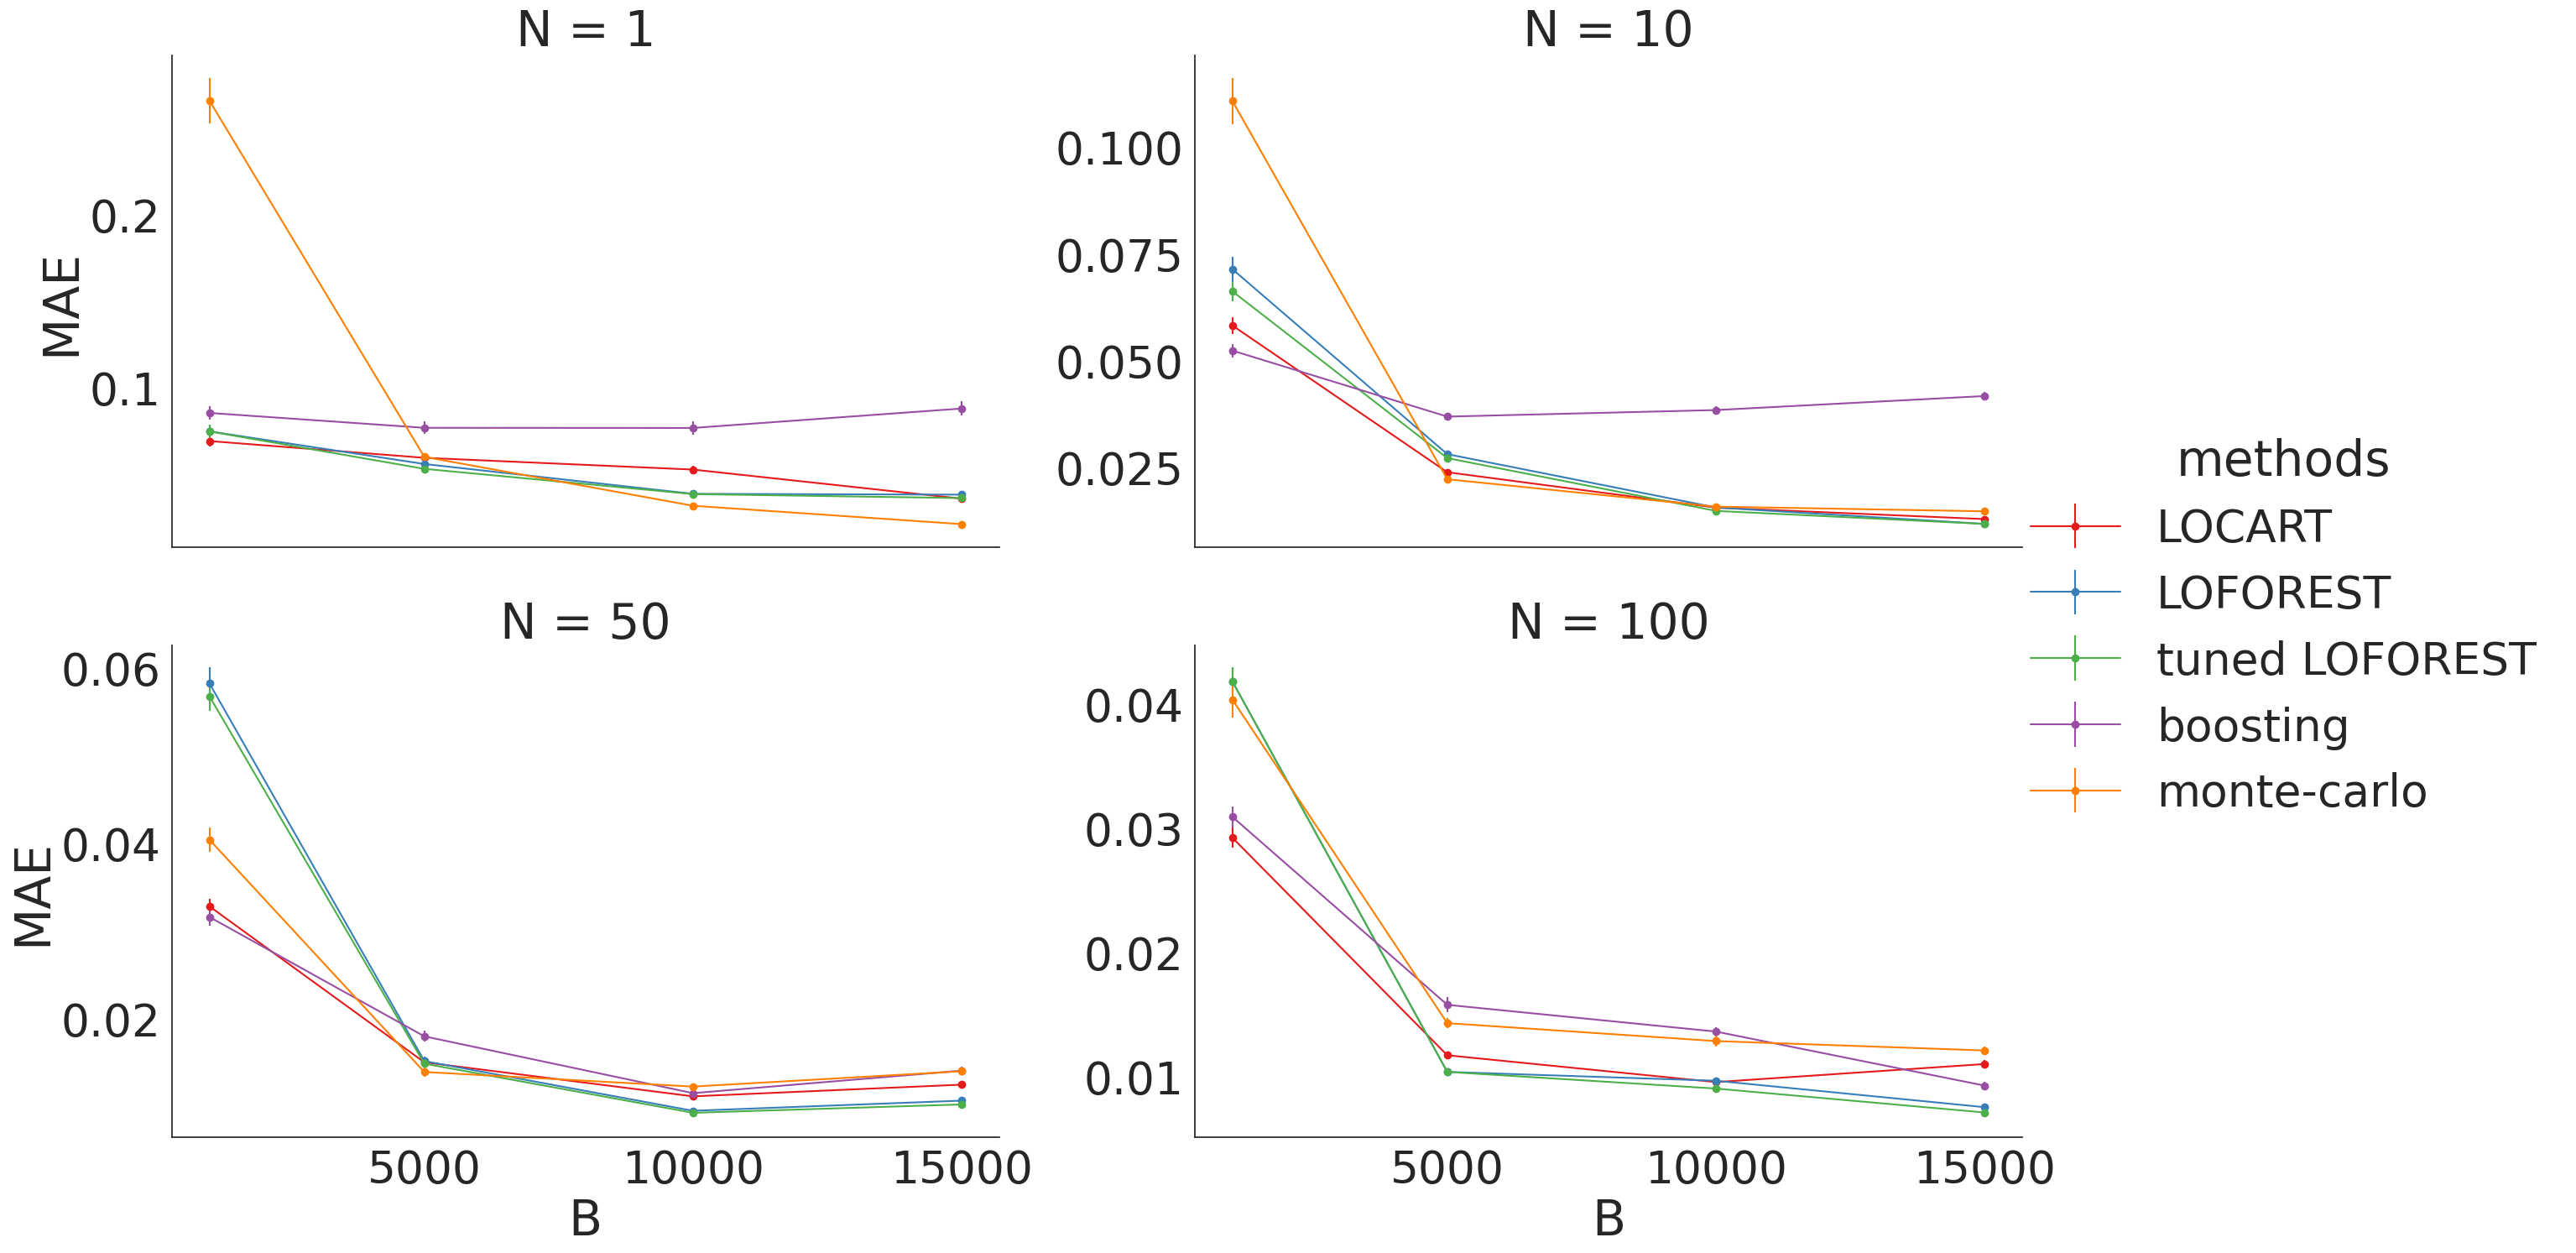

In [6]:
sns.set(style="white", font_scale=3.5)
g = sns.FacetGrid(
    mae_stats_normal,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.60,
    hue="methods",
    palette="Set1",
    margin_titles=True,
    sharey=False,
)
g.map(plt.errorbar, "B", "MAE", "se", marker="o", fmt="-o")
g.add_legend()

# Show the plot
plt.show()

## Testing BFF for $X|\theta \sim 0.5 N(\theta, 1) + 0.5 N(-\theta, 1)$

In [7]:
n_out = 300
thetas_grid = np.linspace(0, 4.999, n_out)

In [8]:
mae_stats_gmm = compute_MAE_N(
    kind_model = "gmm",
    thetas = thetas_grid,
    N=np.array([1, 10, 50, 100]),
    B=np.array([1000, 5000, 10000, 15000]),
    naive_n=250,
    min_samples_leaf=300,
    n_estimators=200,
    seed = 1250,
    K = 50,
)

Computing for B = 1000 and N = 1
Computing for B = 5000 and N = 1
Computing for B = 10000 and N = 1
Computing for B = 15000 and N = 1
Computing for B = 1000 and N = 10
Computing for B = 5000 and N = 10
Computing for B = 10000 and N = 10
Computing for B = 15000 and N = 10
Computing for B = 1000 and N = 50
Computing for B = 5000 and N = 50
Computing for B = 10000 and N = 50
Computing for B = 15000 and N = 50
Computing for B = 1000 and N = 100
Computing for B = 5000 and N = 100
Computing for B = 10000 and N = 100
Computing for B = 15000 and N = 100


/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> ma

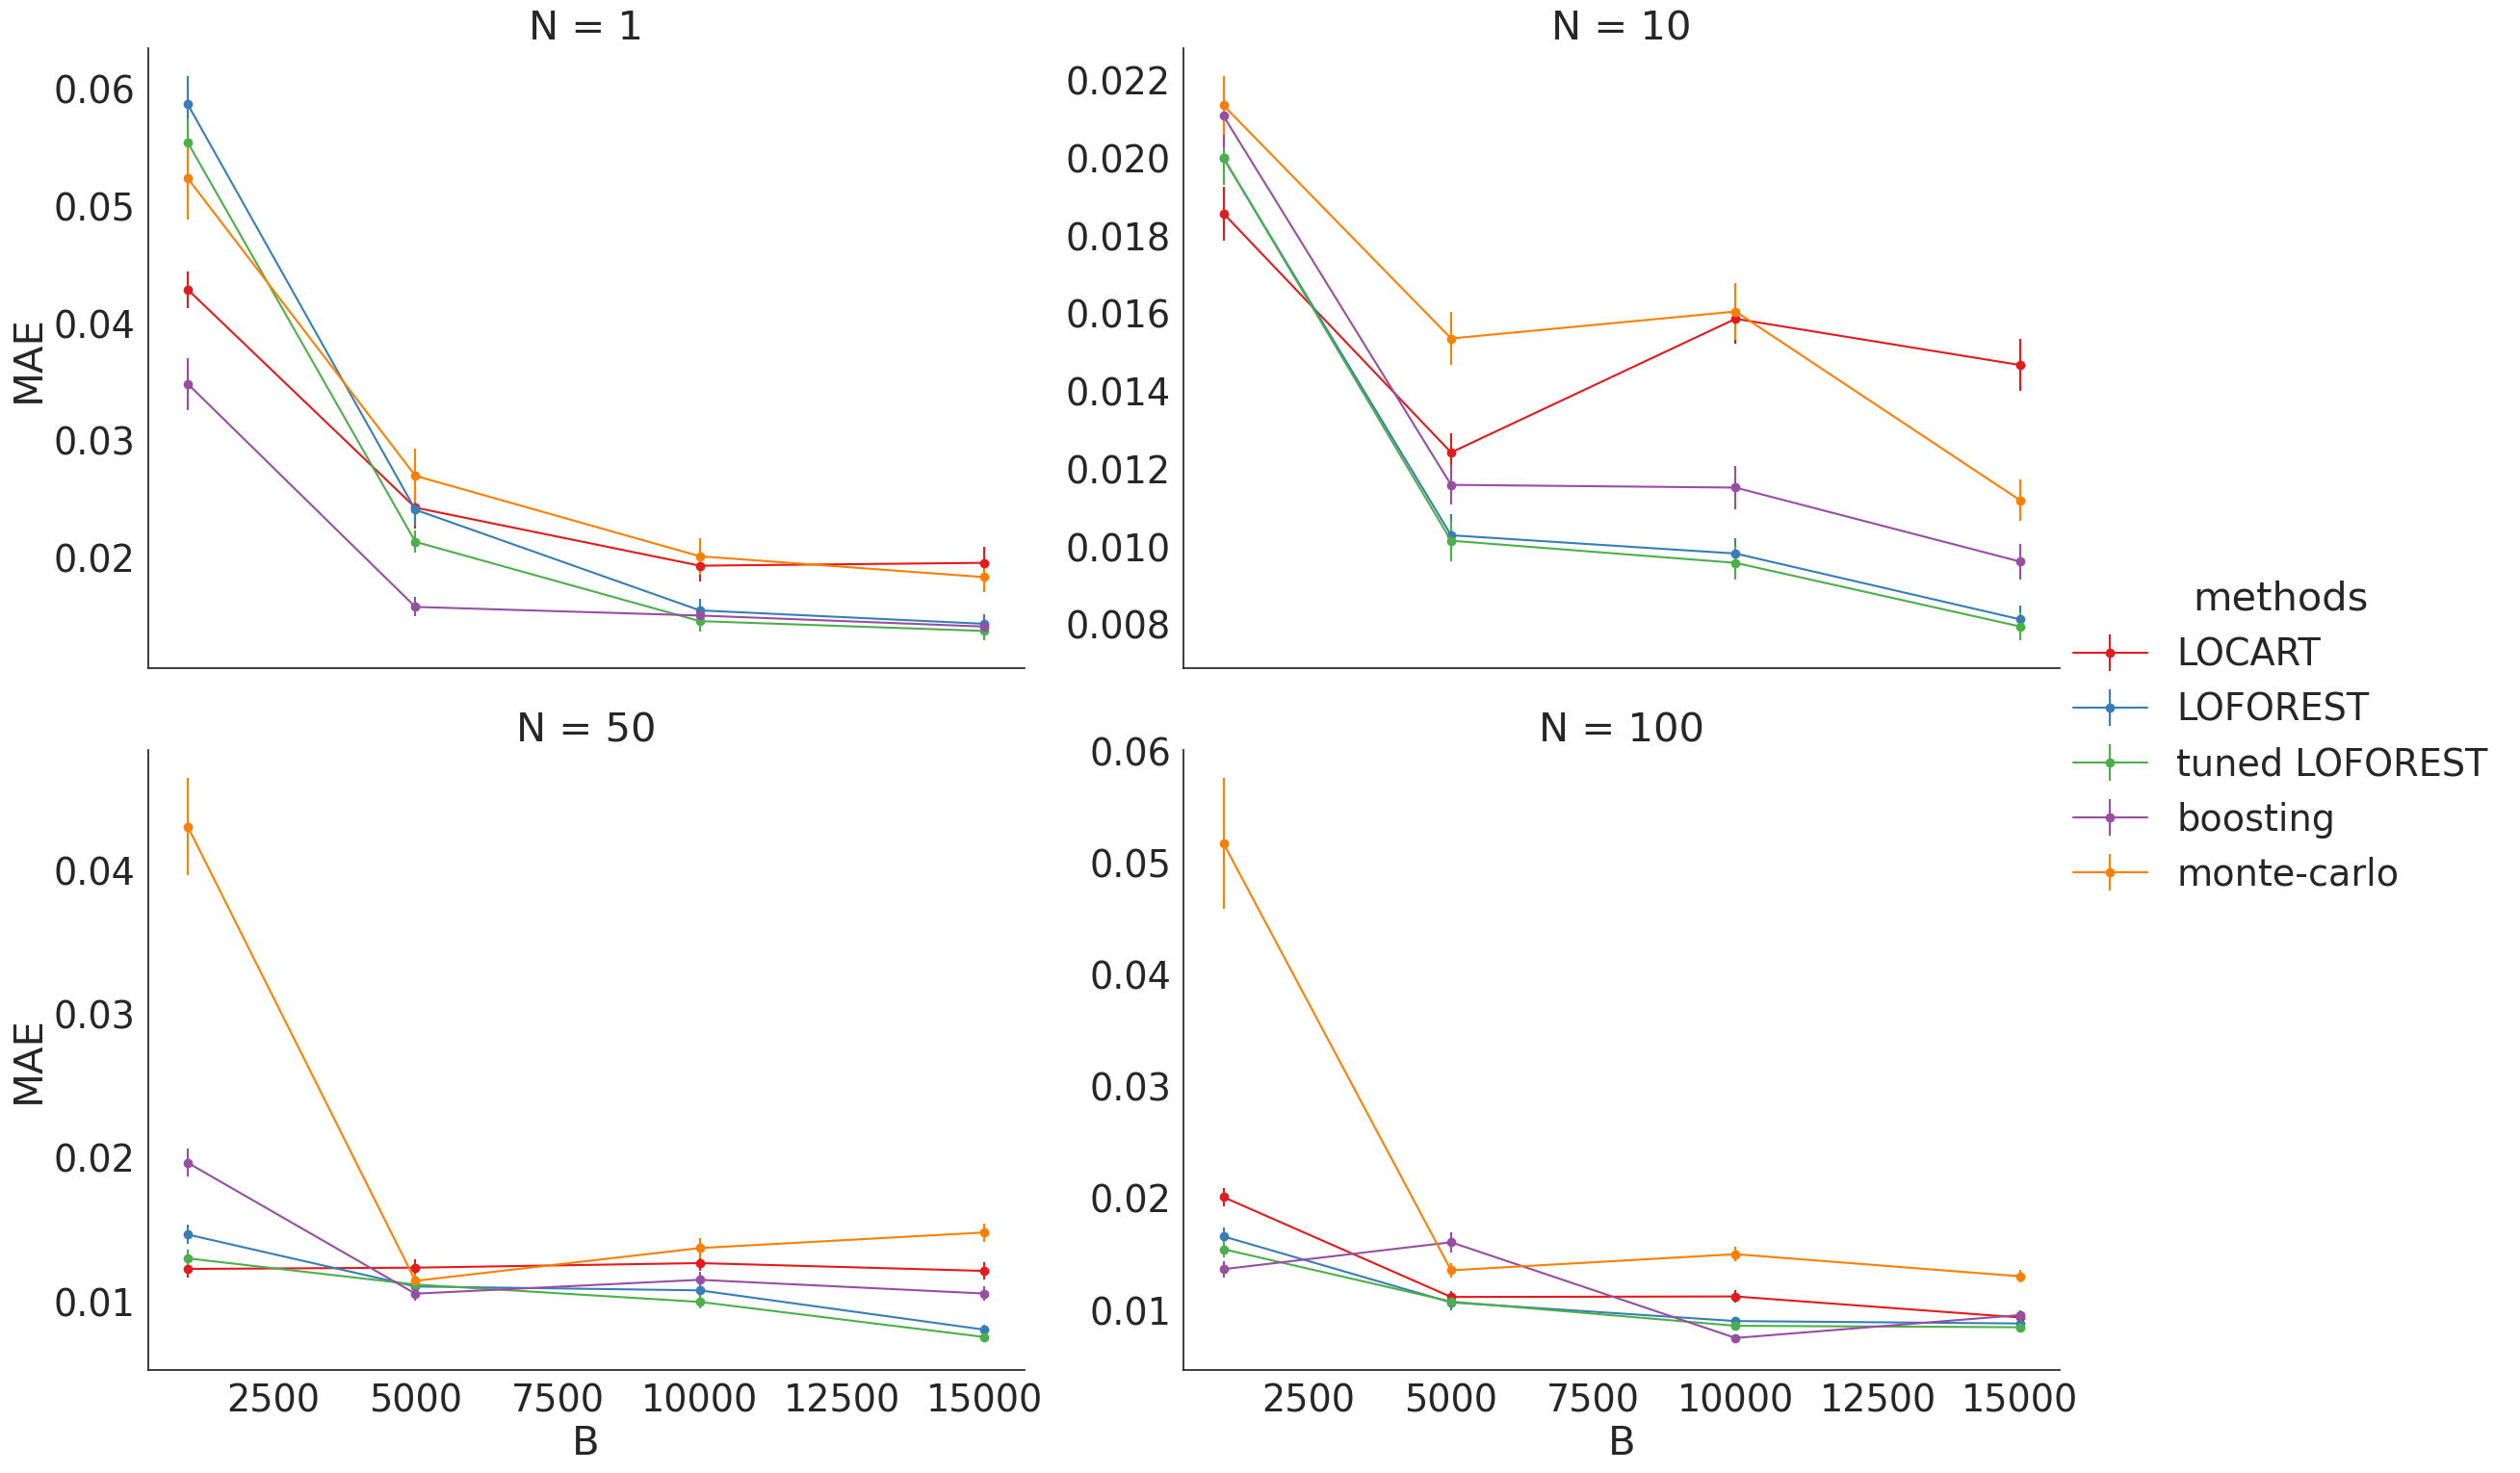

In [16]:
sns.set(style="white", font_scale=2.5)
g = sns.FacetGrid(
    mae_stats_gmm,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.40,
    hue="methods",
    palette="Set1",
    margin_titles=True,
    sharey=False,
)
g.map(plt.errorbar, "B", "MAE", "se", marker="o", fmt="-o")
g.add_legend()

# Show the plot
plt.show()

Plotting only for 50 and 100:

In [10]:
n_out = 300
thetas_grid = np.linspace(0, 4.999, n_out)

In [11]:
mae_stats = compute_MAE_N(
    kind_model = "gmm",
    thetas = thetas_grid,
    N=np.array([1]),
    B=np.array([1000, 5000, 10000, 15000]),
    naive_n=250,
    min_samples_leaf=300,
    n_estimators=200,
    seed = 1250,
    K = 50,
)

Computing for B = 1000 and N = 1
Computing for B = 5000 and N = 1
Computing for B = 10000 and N = 1
Computing for B = 15000 and N = 1


/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> ma

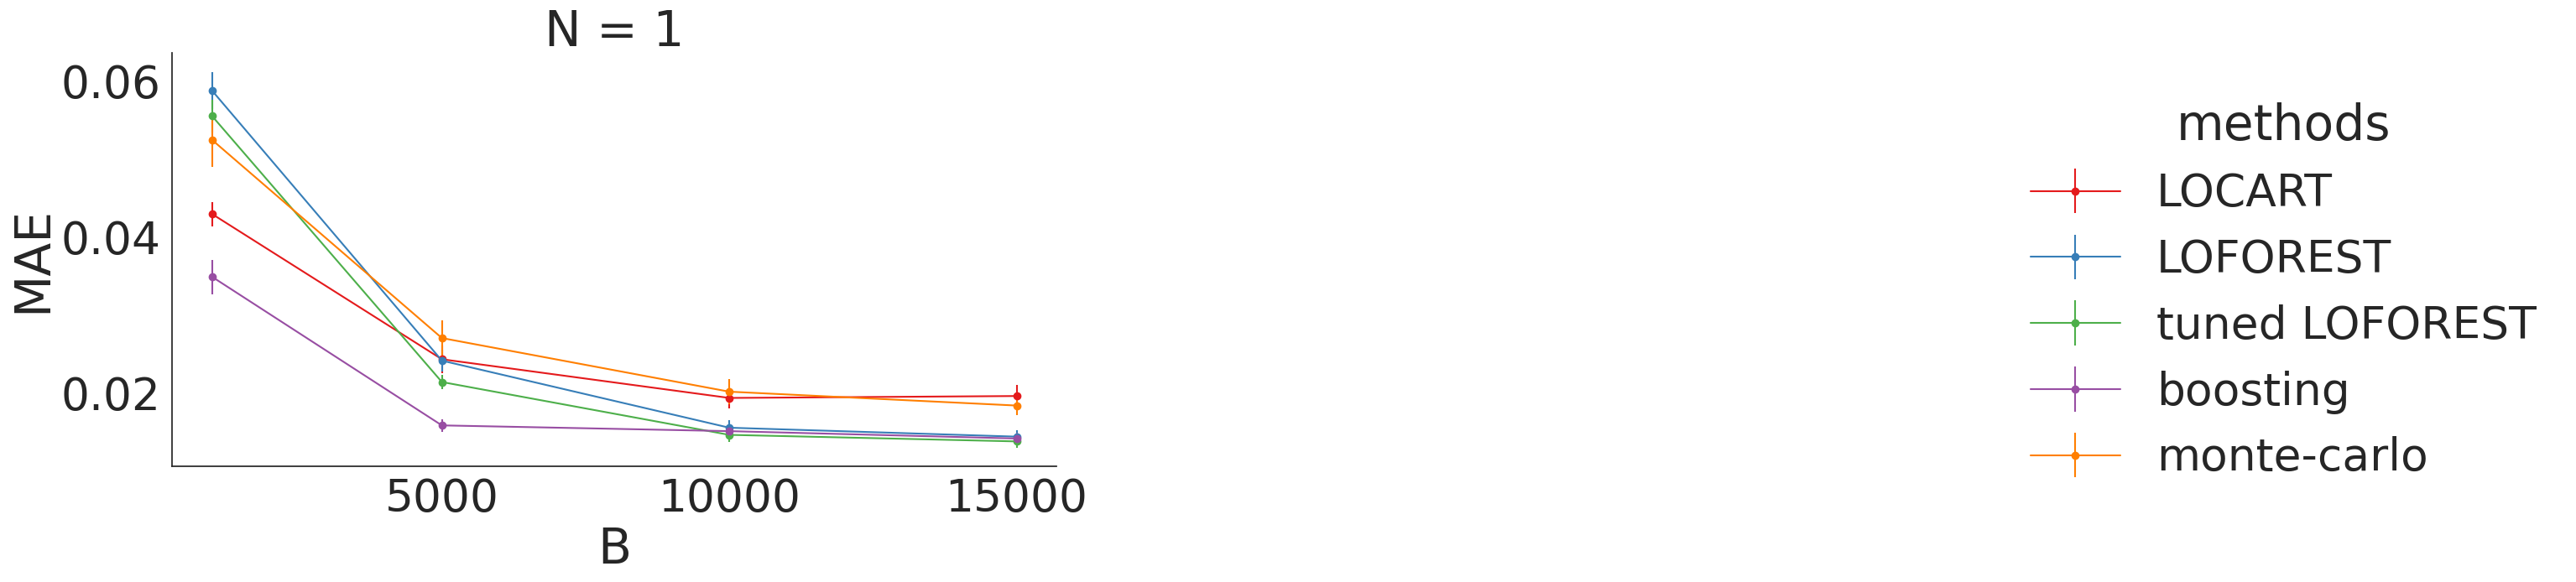

In [12]:
sns.set(style="white", font_scale=3.5)
g = sns.FacetGrid(
    mae_stats,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.60,
    hue="methods",
    palette="Set1",
    margin_titles=True,
    sharey=False,
)
g.map(plt.errorbar, "B", "MAE", "se", marker="o", fmt="-o")
g.add_legend()

# Show the plot
plt.show()

## Testing BFF for $X|\theta \sim \text{lognormal}(\mu, \sigma^2)$

In [13]:
n_out = 50
a_s = np.linspace(-2.4999, 2.4999, n_out)
b_s = np.linspace(0.15001, 1.2499, n_out)
thetas_grid = np.c_[list(itertools.product(a_s, b_s))]

In [14]:
mae_stats_lognormal = compute_MAE_N(
    kind_model = "lognormal",
    thetas = thetas_grid,
    N=np.array([1, 10, 50, 100]),
    B=np.array([1000, 5000, 10000]),
    naive_n= 250,
    min_samples_leaf=300,
    n_estimators=200,
    seed = 125,
    K = 50,
)

Computing for B = 1000 and N = 1
Computing for B = 5000 and N = 1
Computing for B = 10000 and N = 1
Computing for B = 1000 and N = 10
Computing for B = 5000 and N = 10
Computing for B = 10000 and N = 10
Computing for B = 1000 and N = 50
Computing for B = 5000 and N = 50
Computing for B = 10000 and N = 50
Computing for B = 1000 and N = 100
Computing for B = 5000 and N = 100
Computing for B = 10000 and N = 100


/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> marker='o'). The keyword argument will take precedence.
  func(*plot_args, **plot_kwargs)
/home/kuben45/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:848: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-o" (-> ma

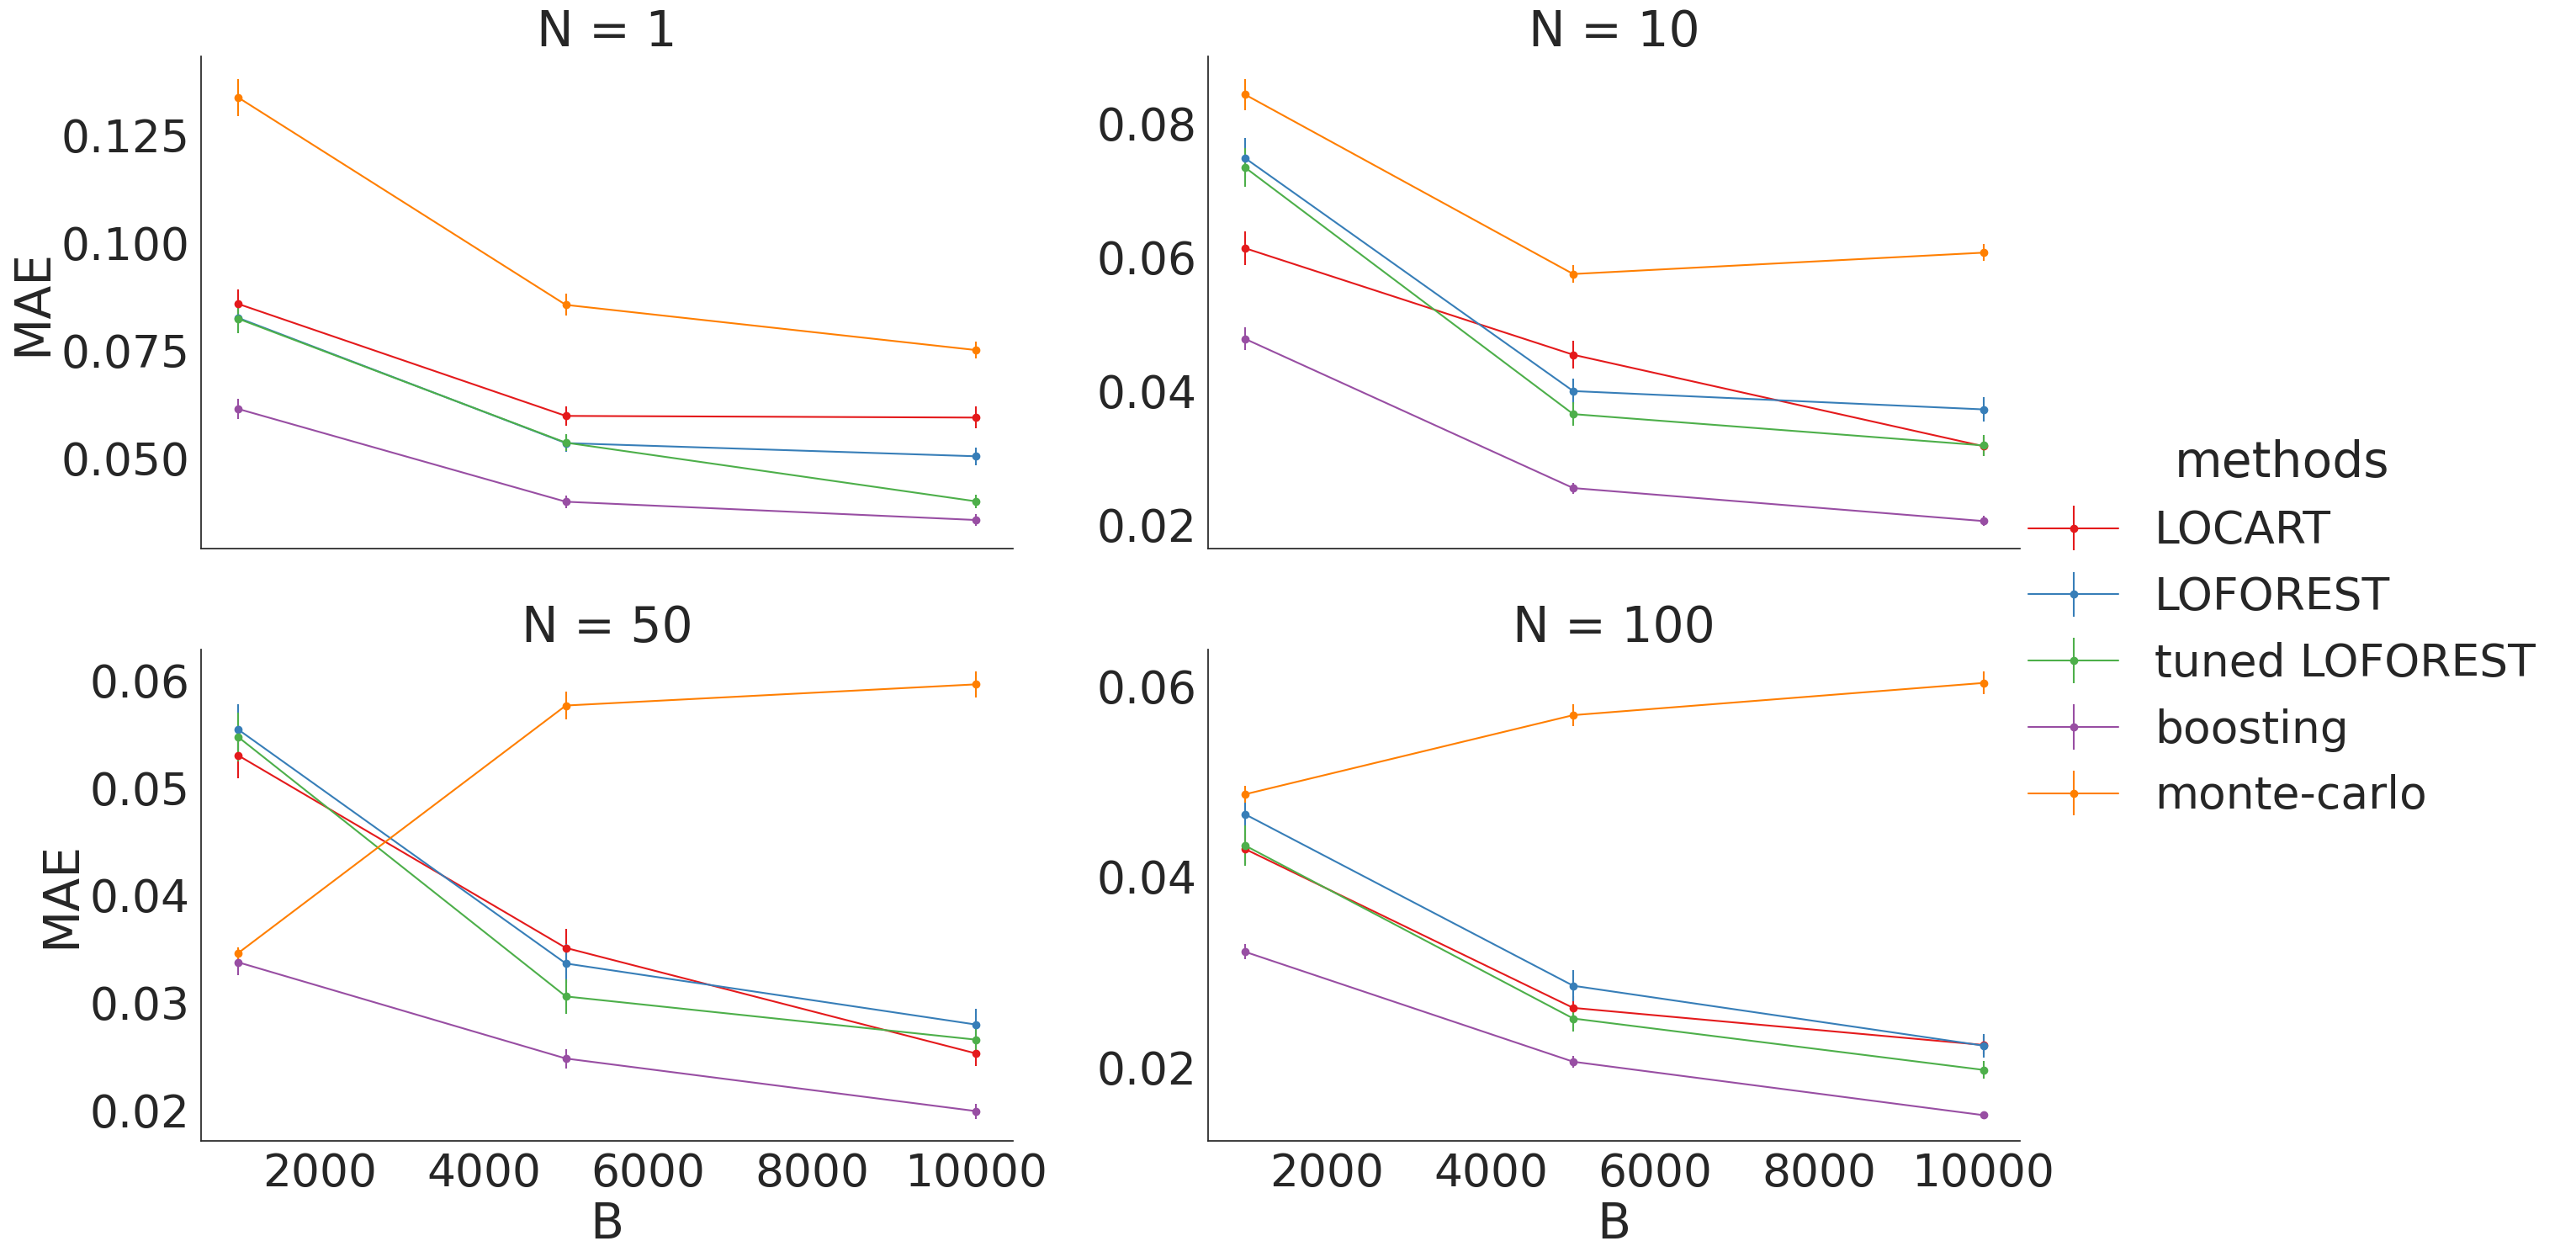

In [15]:
sns.set(style="white", font_scale=3.5)
g = sns.FacetGrid(
    mae_stats_lognormal,
    col="N",
    col_wrap=2,
    height=8,
    aspect=1.60,
    hue="methods",
    palette="Set1",
    margin_titles=True,
    sharey=False,
)
g.map(plt.errorbar, "B", "MAE", "se", marker="o", fmt="-o")
g.add_legend()

# Show the plot
plt.show()

Save all data for latter:

In [17]:
models = ["normal", "gmm", "lognormal"]
for model in models:
    var_name = "mae_stats_" + model
    df = globals()[var_name]
    # Salva o dataframe em um arquivo CSV
    df.to_csv(f"temp_data/BFF_{var_name}.csv", index=False)